In [110]:
import ast
import kenlm
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import sentencepiece
import string
import swifter

from datasets import load_dataset, load_from_disk, DatasetDict
from huggingface_hub import HfApi

In [111]:
text_length_cutoff = 25000
perplexity_cutoff = 5000


def get_perplexity(meta):
    if isinstance(meta, str):
        meta = ast.literal_eval(meta)
    return int(meta["perplexity_score"])


def get_datasets():
    ola_datasets = [
        ds_info.id
        for ds_info in HfApi().list_datasets(
            use_auth_token=os.environ.get("HUGGINGFACE_TOKEN")
        )
        if (
            ds_info.id.startswith("ola13/small-")
            and not ds_info.id.startswith("ola13/small-roots")
        )
        or ds_info.id == "ola13/small-roots_en"
    ]
    datasets = {
        name.split("-")[-1]: pd.DataFrame(
            load_dataset(name, use_auth_token=os.environ.get("HUGGINGFACE_TOKEN"))[
                "train"
            ]
        )
        for name in ola_datasets
    }
    max_perplexity = 0
    min_length = 1000000
    max_length = 0
    for name in datasets.keys():
        dataset = datasets[name]
        dataset["perplexity_score"] = dataset.apply(
            lambda doc: get_perplexity(doc["meta"]), axis=1
        )
        dataset["text_length"] = dataset.apply(lambda doc: len(doc["text"]), axis=1)
        dataset["text_length_clipped"] = dataset.apply(
            lambda doc: doc["text_length"]
            if doc["text_length"] < text_length_cutoff
            else text_length_cutoff,
            axis=1,
        )
        dataset["perplexity_score_clipped"] = dataset.apply(
            lambda doc: doc["perplexity_score"]
            if doc["perplexity_score"] < perplexity_cutoff
            else perplexity_cutoff,
            axis=1,
        )
        for column in dataset.columns:
            if column not in [
                "text",
                "perplexity_score",
                "text_length",
                "text_length_clipped",
                "perplexity_score_clipped",
            ]:
                dataset = dataset.drop(column, axis=1)

        datasets[name] = dataset.sort_values("perplexity_score")
        datasets[name] = datasets[name].reset_index()
        max_perp = dataset["perplexity_score"].max()
        min_len = dataset["text_length"].min()
        max_len = dataset["text_length"].max()
        max_perplexity = max(max_perp, max_perplexity)
        min_length = min(min_len, min_length)
        max_length = max(max_len, max_length)
    return datasets, max_perplexity, min_length, max_length

In [112]:
datasets, max_perplexity, min_length, max_length = get_datasets()

Using custom data configuration ola13--small-the_pile-4ea951960b8e9f8a
Found cached dataset parquet (/mnt/disks/looking_glass_storage/hf_cache/ola13___parquet/ola13--small-the_pile-4ea951960b8e9f8a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration ola13--small-c4-f67537b3f2cb384f
Found cached dataset parquet (/mnt/disks/looking_glass_storage/hf_cache/ola13___parquet/ola13--small-c4-f67537b3f2cb384f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration ola13--small-oscar-b6e18b392b221046
Found cached dataset parquet (/mnt/disks/looking_glass_storage/hf_cache/ola13___parquet/ola13--small-oscar-b6e18b392b221046/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration ola13--small-roots_en-11cad66076508e44
Found cached dataset parquet (/mnt/disks/looking_glass_storage/hf_cache/ola13___parquet/ola13--small-roots_en-11cad66076508e44/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [113]:
colors = ["blue", "green", "lime", "cyan"]

In [201]:
perplexity_threshold = 1500

def plot_perplexity_histogram(perplexity_key="perplexity_score_clipped", bins=500, ylim=3000):
    plt.figure(figsize=(15, 5))
    legend_patches = []
    for i, (dataset_name, dataset) in enumerate(datasets.items()):
        x = dataset[perplexity_key]
        plt.hist(x, bins, facecolor=colors[i], alpha=0.75)
        in_count = len(dataset[dataset[perplexity_key] <= perplexity_threshold])
        in_ratio = (100 * in_count)/ len(dataset)
        legend_patches.append(mpatches.Patch(color=colors[i], label=dataset_name + " In ratio: " + str(in_ratio)))

    plt.xlim(0, perplexity_cutoff + 100)
    plt.ylim(0, ylim)

    plt.axvline(x=perplexity_threshold, linewidth=0.5, color="red")
    plt.xlabel("Perplexity")
    plt.ylabel("Count")
    plt.title("Histogram of Perplexities")
    plt.legend(handles=legend_patches)
    
    plt.show()

In [202]:
def plot_text_length_histogram():
    plt.figure(figsize=(15, 5))
    legend_patches = []
    for i, (dataset_name, dataset) in enumerate(datasets.items()):
        x = dataset["text_length_clipped"]
        n, bins, patches = plt.hist(x, 500, facecolor=colors[i], alpha=0.75)
        legend_patches.append(mpatches.Patch(color=colors[i], label=dataset_name))

    plt.xlim(0, text_length_cutoff + 100)
    plt.ylim(0, 10500)

    plt.xlabel("Text Length")
    plt.ylabel("Count")
    plt.title("Histogram of Text Lengths")
    plt.legend(handles=legend_patches)

    plt.show()

In [203]:
def plot_simple(dataset_name):
    dataset = datasets[dataset_name]
    plt.figure(figsize=(15, 5))

    x = dataset["text_length"]
    y = dataset["perplexity_score"]

    plt.xlim(0, 10000)
    plt.ylim(0, 5000)

    plt.scatter(x, y, marker=".", s=1, color="g", linewidths=0)

    plt.xlabel("Perplexity")
    plt.ylabel("Text length")
    plt.title(dataset_name)
    x = np.linspace(0, 10000, 100)
    y = 590 + 10000/np.cbrt(x)

    # plot the function
    plt.plot(x, y, 'r')
    
    
    y2 = 590 -10000/ np.cbrt(x)
    plt.plot(x, y2, 'r')
    plt.axhline(y=590, color="k", linestyle="-", linewidth=0.5)
    return plt

In [204]:
def plot_full(dataset_name, cutoff, perplexity_key="perplexity_score", length_key="text_length"):
    dataset = datasets[dataset_name]
    plt.figure(figsize=(15, 5))

    idx_in = dataset[dataset[perplexity_key] < cutoff].index
    idx_out = dataset[dataset[perplexity_key] >= cutoff].index

    x_in = dataset[length_key].iloc[idx_in]
    y_in = dataset[perplexity_key].iloc[idx_in]

    x_out = dataset[length_key].iloc[idx_out]
    y_out = dataset[perplexity_key].iloc[idx_out]

    plt.xlim(0, perplexity_cutoff + 100)
    plt.ylim(0, 5000)

    plt.scatter(x_in, y_in, marker=".", s=1, color="g", linewidths=0)
    plt.scatter(x_out, y_out, marker=".", s=1, color="r", linewidths=0)

    plt.axhline(y=perplexity_threshold, color="b", linestyle="-", linewidth=0.5)
    included = len(dataset[dataset[perplexity_key] < 1500])
    ratio = (100 * included) / len(dataset)
    plt.text(
        perplexity_cutoff - 1500,
        1550,
        "Current threshold, included ratio: " + str(ratio),
        color="b",
    )

    plt.axhline(y=cutoff, color="k", linestyle="-", linewidth=0.5)
    ratio = 100 * (len(dataset) - len(x_out)) / len(dataset)
    plt.text(perplexity_cutoff - 1500, 3500, "Green ratio: " + str(ratio), fontsize=15)

    plt.xlabel("Text length")
    plt.ylabel("Perplexity")
    plt.title(dataset_name)
    plt.show()
    return plt

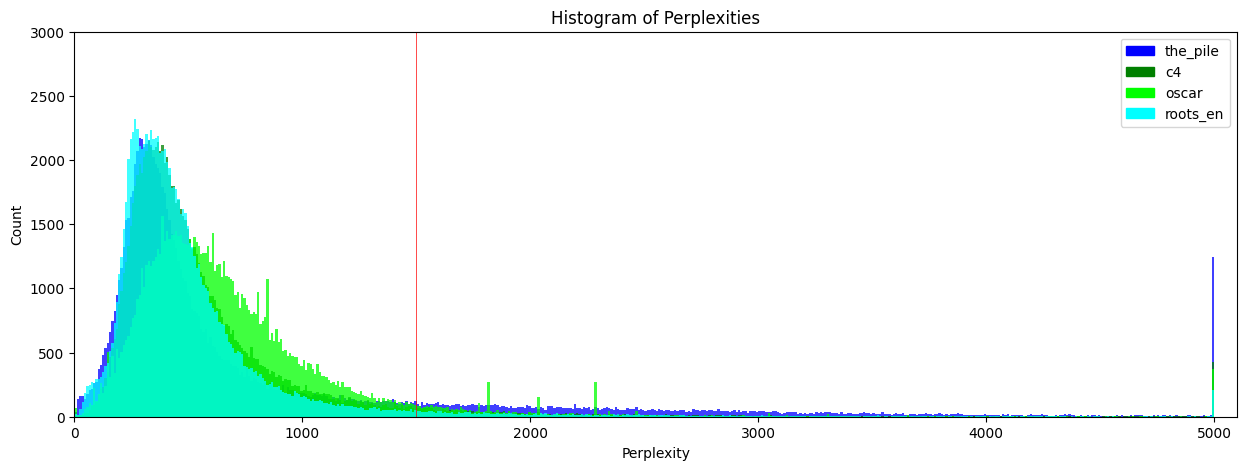

In [118]:
plot_perplexity_histogram()

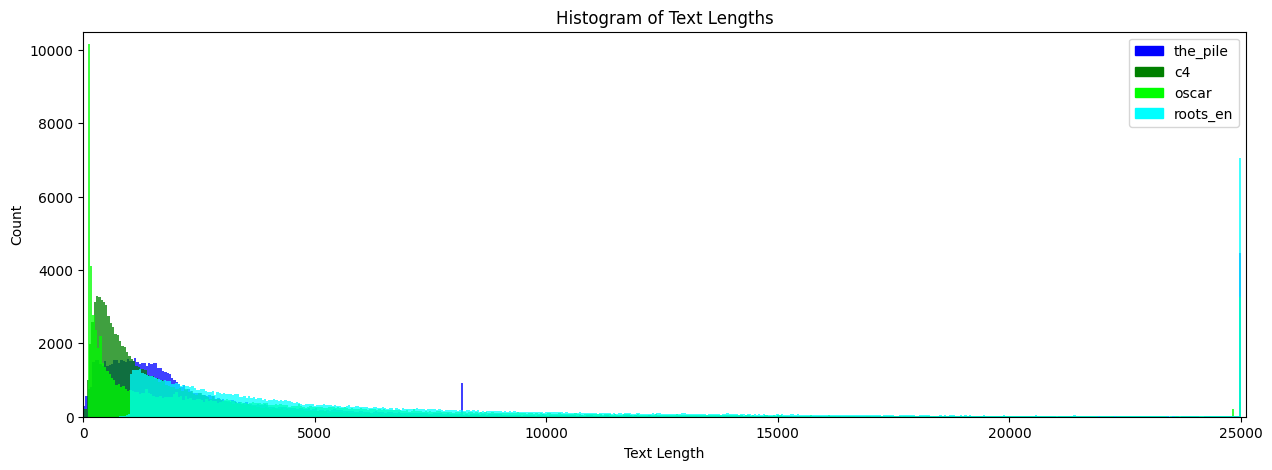

In [119]:
plot_text_length_histogram()

/tmp/ipykernel_98659/1001181736.py:17: RuntimeWarning: divide by zero encountered in divide
  y = 590 + 10000/np.cbrt(x)
/tmp/ipykernel_98659/1001181736.py:23: RuntimeWarning: divide by zero encountered in divide
  y2 = 590 -10000/ np.cbrt(x)


<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.9/site-packages/matplotlib/pyplot.py'>

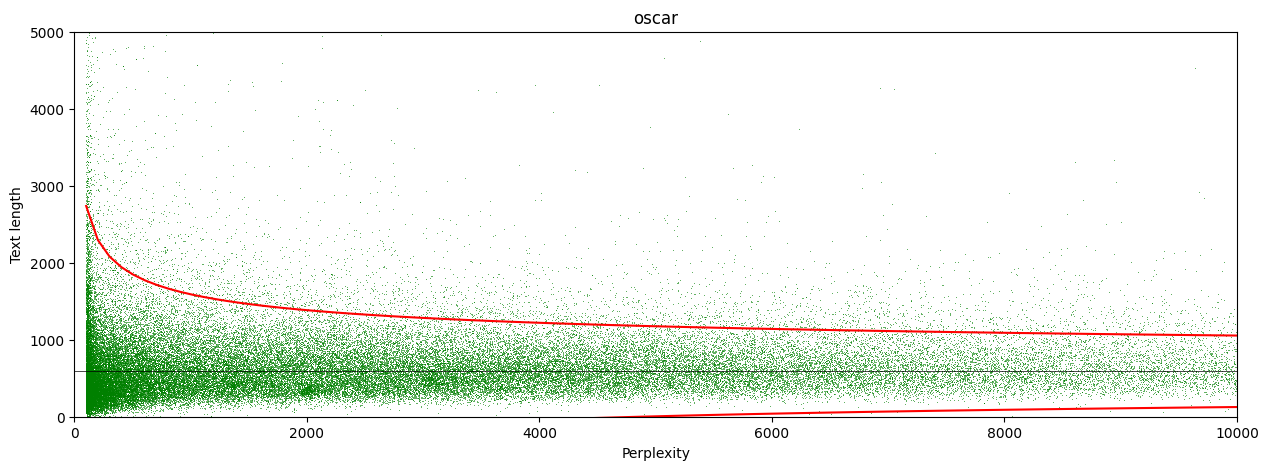

In [120]:
plot_simple("oscar")

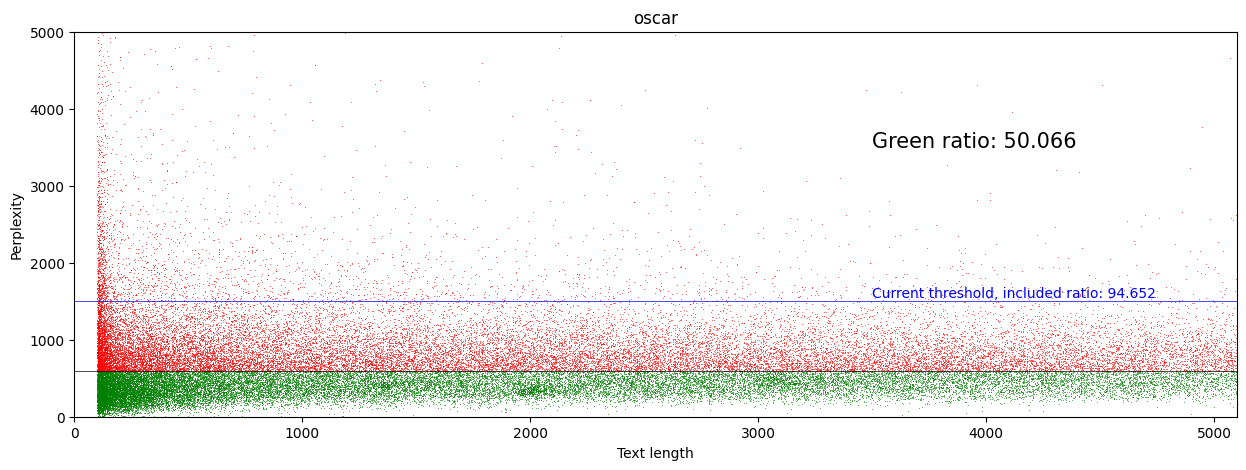

In [121]:
oscar_cutoff = 590
plt_base = plot_full("oscar", oscar_cutoff)

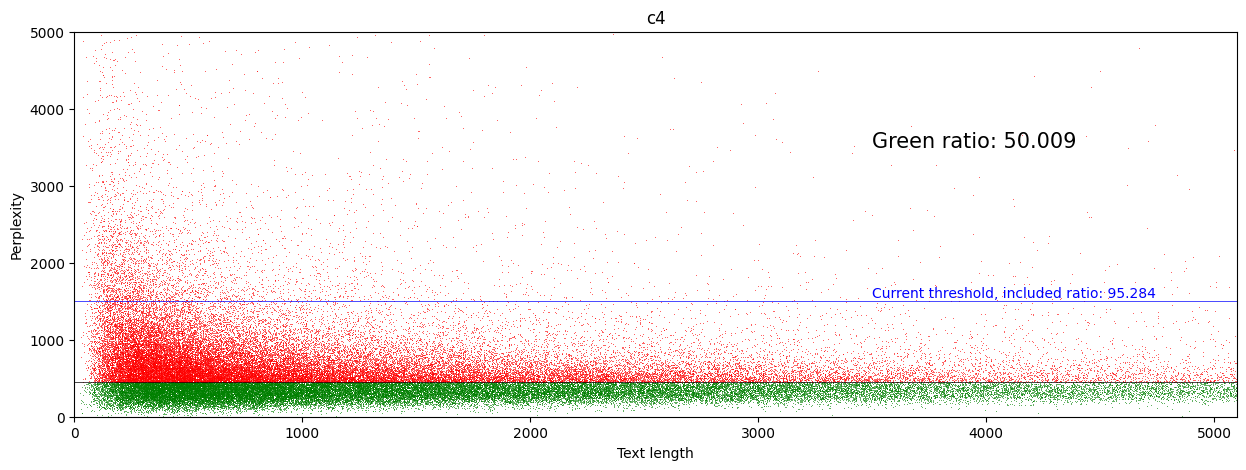

In [122]:
c4_cutoff = 451
plt_base = plot_full("c4", c4_cutoff)

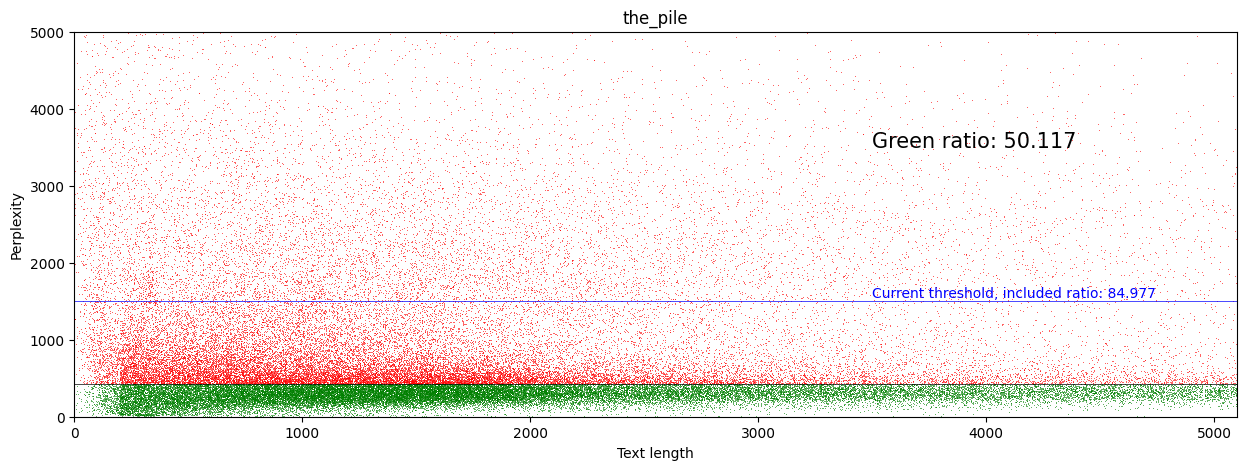

In [123]:
the_pile_cutoff = 431
plt_base = plot_full("the_pile", the_pile_cutoff)

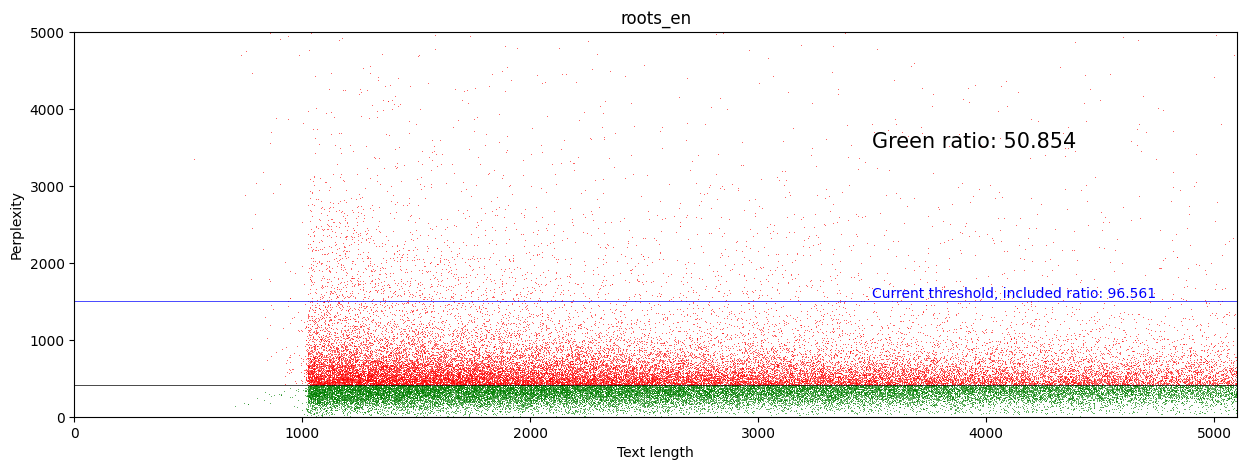

In [124]:
roots_en_cutoff = 415
plt_base = plot_full("roots_en", roots_en_cutoff)

fixed length (eg max 1024 or whatever) randomly sampled spans in larger documents to compute the perplexity and plot the perplexity versus total text length to see if the convergence to ~400 still hold?

In [125]:
def find_whitespace(text):
    for i, c in enumerate(text):
        if c in string.whitespace:
            yield i


def get_segmentation(text, passage_tokens, overlap_tokens):
    whitespace_idx = [-1] + list(find_whitespace(text))
    unique_tokens = passage_tokens - overlap_tokens
    passages = []
    for i in range(0, len(whitespace_idx), unique_tokens):
        if i + passage_tokens >= len(whitespace_idx):
            passages.append((whitespace_idx[i] + 1, len(text)))
            break
        passages.append((whitespace_idx[i] + 1, whitespace_idx[i + passage_tokens] + 1))
    return passages

In [126]:
def remove_non_printing_characters(document, non_printing_characters_re):
    return non_printing_characters_re.sub("", document)


def uniform_whitespace(
    document,
    whitespace=[
        " ",
        " ",
        " ",
        " ",
        " ",
        "　",
        " ",
        " ",
        " ",
        " ",
        "￼",
        "",
    ],
):
    """There are different whitespace characters."""
    whitespace = set(whitespace)
    document = "".join(
        [char if char not in whitespace else " " for char in document]
    )
    return document


def replace_digits_with_zeros(document, digits_re):
    return digits_re.sub("0", document)


def replace_unicode_punctuation(document, unicode_punctuation):
    return "".join(unicode_punctuation.get(c, c) for c in document)

In [127]:
def tokenization(document, sentencepiece_model, join_on_whitespace):
    document_tokenized = sentencepiece_model.encode_as_pieces(document)
    if join_on_whitespace:
        document_tokenized = " ".join(document_tokenized)
    return document_tokenized


def normalization(
    document,
    remove_non_printing_characters_cond,
    strip,
    lower_case,
    uniform_whitespace_cond,
    replace_digits_with_zeros_cond,
    replace_unicode_punctuation_cond,
    non_printing_characters_re,
    digits_re,
    unicode_punctuation,
):
    if remove_non_printing_characters_cond:
        document = remove_non_printing_characters(
            document, non_printing_characters_re
        )
    if strip:
        document = document.strip()
    if not document:
        return document
    if lower_case:
        document = document.lower()
    if uniform_whitespace_cond:
        document = uniform_whitespace(document)
    if replace_digits_with_zeros_cond:
        document = replace_digits_with_zeros(document, digits_re)
    if replace_unicode_punctuation_cond:
        document = replace_unicode_punctuation(
            document, unicode_punctuation
        )
    return document

In [128]:
def load_sentencepiece_model(path_sentencepiece_model):
    sentencepiece_model = sentencepiece.SentencePieceProcessor()
    sentencepiece_model.load(path_sentencepiece_model)
    return sentencepiece_model

def load_kenlm_model(path_kenlm_model):
    kenlm_model = kenlm.Model(path_kenlm_model)
    return kenlm_model

In [129]:
sentencepiece_model = load_sentencepiece_model("../data/en.sp.model")

In [130]:
kenlm_model = load_kenlm_model("../data/en.arpa.bin")

In [131]:
non_printing_characters_re = re.compile(
    f"[{''.join(map(chr, list(range(0,32)) + list(range(127,160))))}]"
)

digits_re: re.Pattern = re.compile(r"\d")

unicode_punctuation = {
    "，": ",",
    "。": ".",
    "、": ",",
    "„": '"',
    "”": '"',
    "“": '"',
    "«": '"',
    "»": '"',
    "１": '"',
    "」": '"',
    "「": '"',
    "《": '"',
    "》": '"',
    "´": "'",
    "∶": ":",
    "：": ":",
    "？": "?",
    "！": "!",
    "（": "(",
    "）": ")",
    "；": ";",
    "–": "-",
    "—": " - ",
    "．": ". ",
    "～": "~",
    "’": "'",
    "…": "...",
    "━": "-",
    "〈": "<",
    "〉": ">",
    "【": "[",
    "】": "]",
    "％": "%",
    "►": "-",
}


In [175]:
def compute_perplexity_score(document, sentencepiece_model=sentencepiece_model, kenlm_model=kenlm_model):
    document = normalization(
        document=document,
        remove_non_printing_characters_cond=True,
        strip=True,
        lower_case=False,
        uniform_whitespace_cond=True,
        replace_digits_with_zeros_cond=True,
        replace_unicode_punctuation_cond=True,
        non_printing_characters_re=non_printing_characters_re,
        digits_re=digits_re,
        unicode_punctuation=unicode_punctuation,
    )
    document = tokenization(
        document, sentencepiece_model, join_on_whitespace=True
    )
    doc_log_score, doc_length = 0, 0
    for line in document.split("\n"):
        log_score = kenlm_model.score(line)
        length = len(line.split()) + 1
        doc_log_score += log_score
        doc_length += length
    pp_score = 10.0 ** (-doc_log_score / doc_length)
    pp_score = round(pp_score, 1)
    return pp_score

In [176]:
max_length = 1024
passage_tokens = 256

In [177]:
def choose_passage(row, max_length=max_length, passage_tokens=passage_tokens):
  if row["text_length"] > max_length:
    segments = get_segmentation(row["text"], passage_tokens=passage_tokens, overlap_tokens=0)
    left, right = random.choice(segments)
    return row["text"][left:right]
  return row["text"]

In [179]:
for dataset_name, ds_df in datasets.items():
    print(dataset_name)
    ds_df["passage"] = ds_df.apply(
        lambda doc: choose_passage(doc, max_length=max_length, passage_tokens=passage_tokens), axis=1,
    )
    ds_df["passage_length"] = ds_df.apply(lambda doc: len(doc["passage"]), axis=1)
    ds_df["passage_perplexity"] = ds_df.swifter.apply(
        lambda doc: int(compute_perplexity_score(doc["passage"])), axis=1,
    )
    ds_df["passage_perplexity_clipped"] = ds_df.apply(
        lambda doc: doc["passage_perplexity"]
        if doc["passage_perplexity"] < perplexity_cutoff
        else perplexity_cutoff,
        axis=1,
    )

the_pile


Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

c4


Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

oscar


Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

roots_en


Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

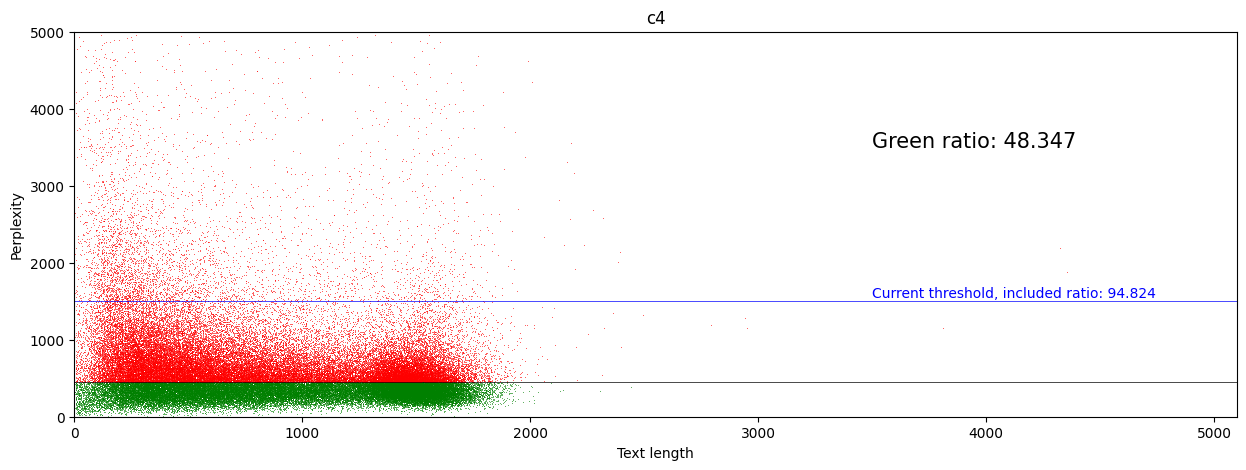

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [180]:
plot_full("c4", c4_cutoff, perplexity_key="passage_perplexity", length_key="passage_length")

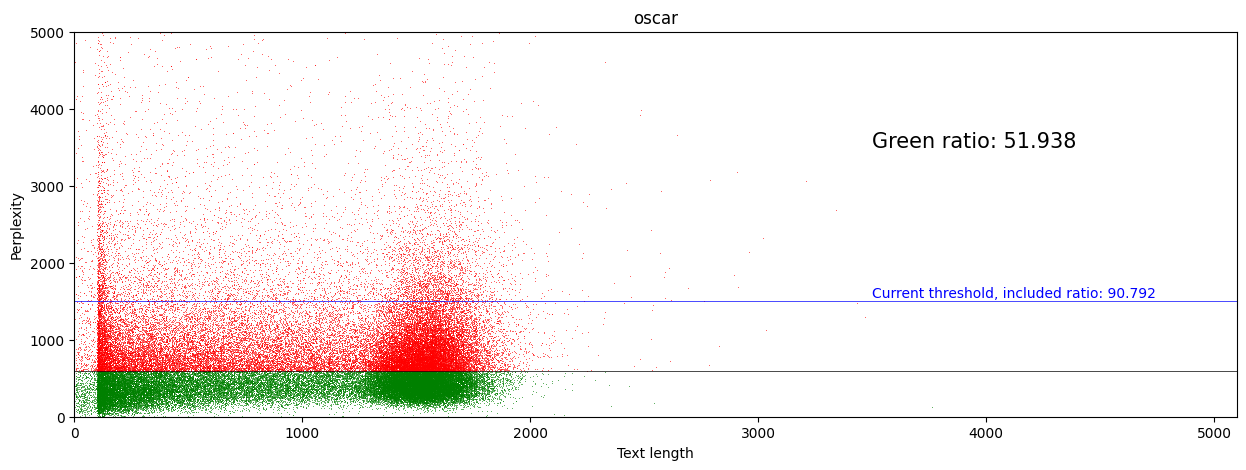

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [181]:
plot_full("oscar", oscar_cutoff, perplexity_key="passage_perplexity", length_key="passage_length")

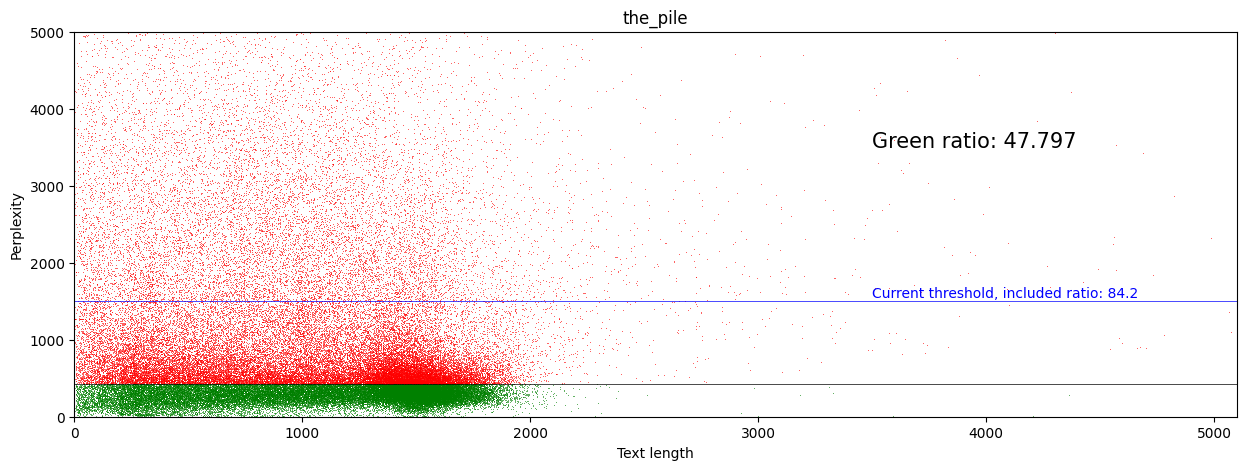

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [182]:
plot_full("the_pile", the_pile_cutoff, perplexity_key="passage_perplexity", length_key="passage_length")

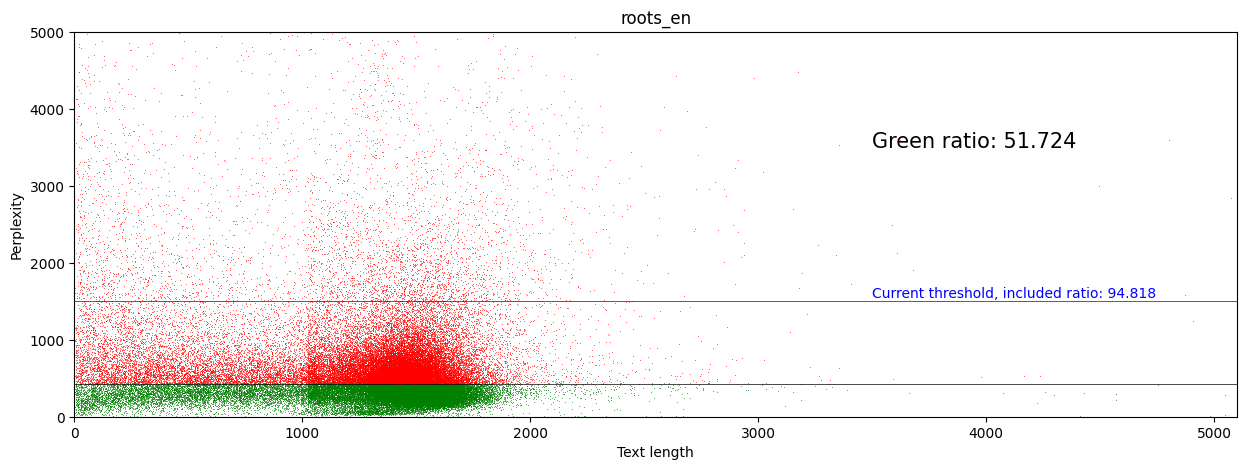

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [183]:
plot_full("roots_en", the_pile_cutoff, perplexity_key="passage_perplexity", length_key="passage_length")

In [184]:
def get_max_perplexity(doc):
    segments = get_segmentation(doc["text"], passage_tokens=1024, overlap_tokens=0)
    passages = [doc["text"][left:right] for left, right in segments]
    perplexities = [int(compute_perplexity_score(passage)) for passage in passages]
    return max(perplexities)

def get_min_perplexity(doc):
    segments = get_segmentation(doc["text"], passage_tokens=1024, overlap_tokens=0)
    passages = [doc["text"][left:right] for left, right in segments]
    perplexities = [int(compute_perplexity_score(passage)) for passage in passages]
    return min(perplexities)

In [185]:
for dataset_name, ds_df in datasets.items():
    print(dataset_name)
    ds_df["max_perplexity"] = ds_df.swifter.apply(lambda doc: get_max_perplexity(doc), axis=1)
    ds_df["min_perplexity"] = ds_df.swifter.apply(lambda doc: get_min_perplexity(doc), axis=1)
    ds_df["max_perplexity_clipped"] =  ds_df.apply(
        lambda doc: doc["max_perplexity"]
        if doc["max_perplexity"] < perplexity_cutoff
        else 2* perplexity_cutoff,
        axis=1,
    )
    ds_df["min_perplexity_clipped"] =  ds_df.apply(
        lambda doc: doc["min_perplexity"]
        if doc["min_perplexity"] < perplexity_cutoff
        else 2* perplexity_cutoff,
        axis=1,
    )

the_pile


Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

c4


Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

oscar


Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

roots_en


Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

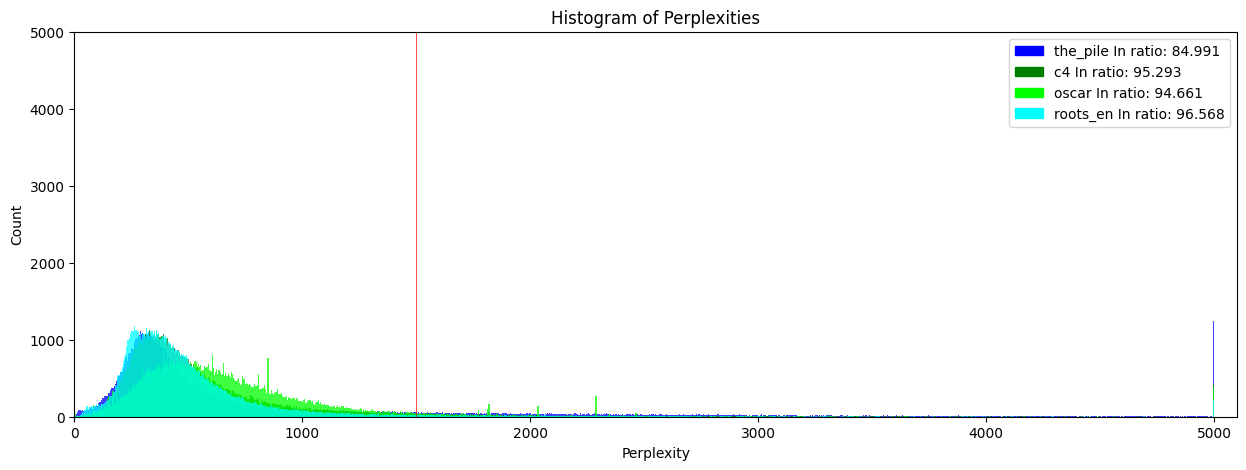

In [205]:
plot_perplexity_histogram(bins=1000, ylim=5000)

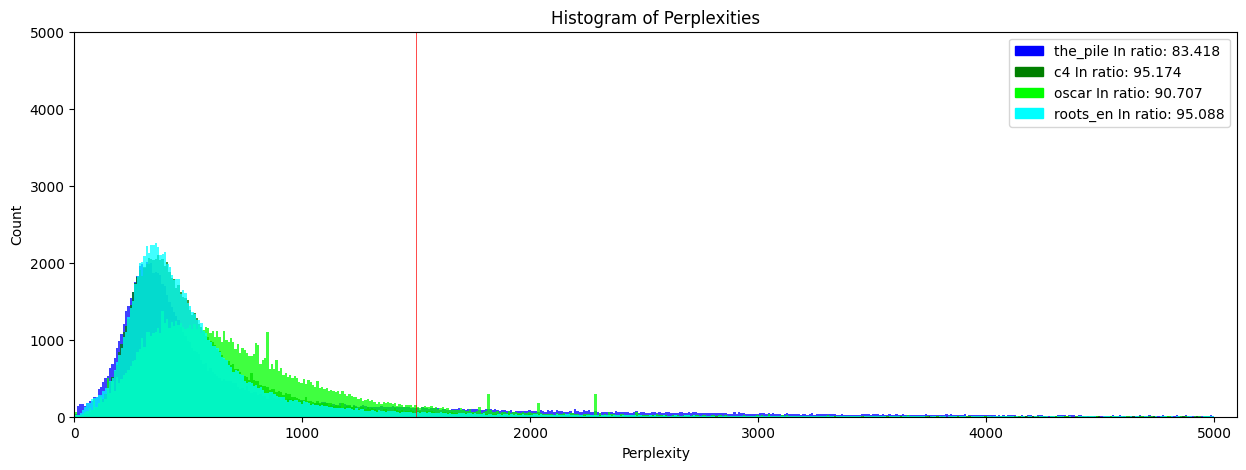

In [206]:
plot_perplexity_histogram(perplexity_key="max_perplexity_clipped", bins=1000, ylim=5000)

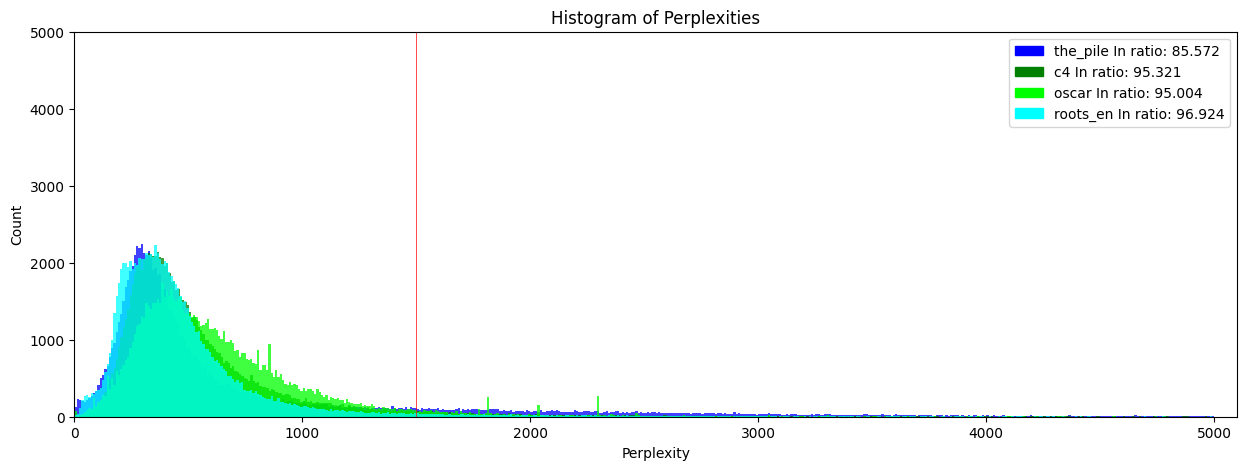

In [207]:
plot_perplexity_histogram(perplexity_key="min_perplexity_clipped", bins=1000, ylim=5000)

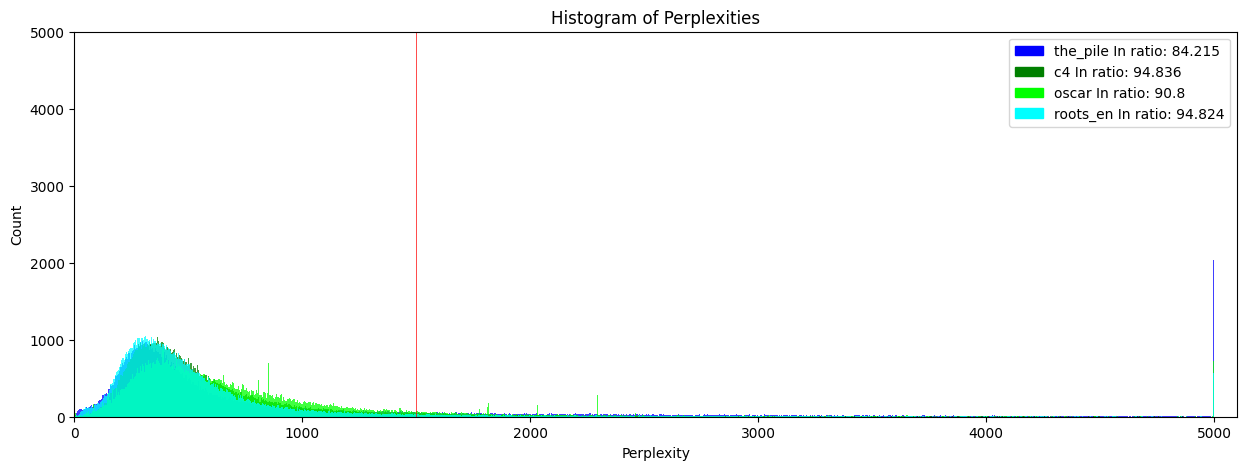

In [208]:
plot_perplexity_histogram(perplexity_key="passage_perplexity_clipped", bins=1000, ylim=5000)

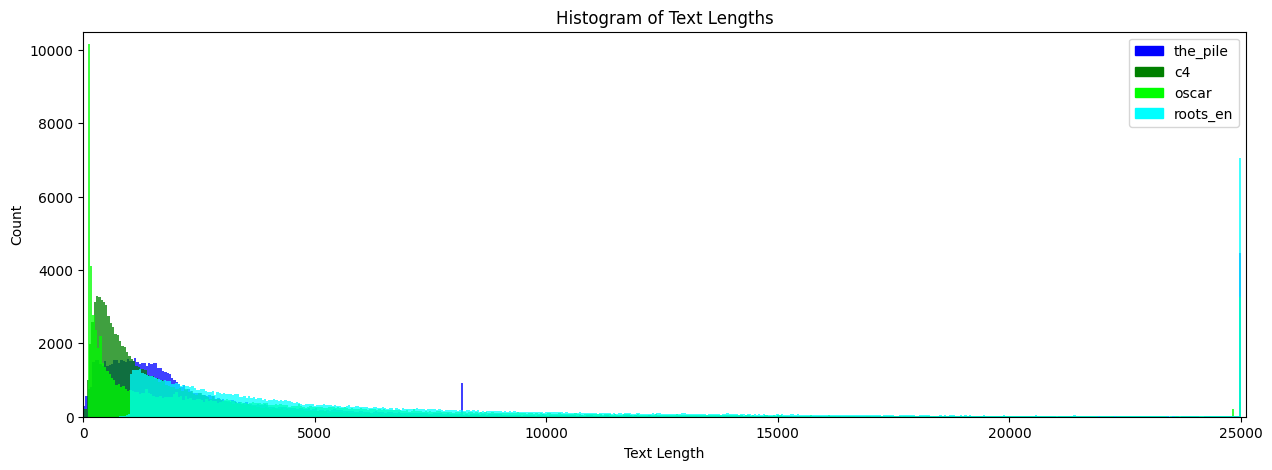

In [209]:
plot_text_length_histogram()

In [210]:
datasets["oscar"]

,index,text,perplexity_score,text_length,text_length_clipped,perplexity_score_clipped,passage,passage_length,passage_perplexity,passage_perplexity_clipped,max_perplexity,min_perplexity,max_perplexity_clipped,min_perplexity_clipped
0,13571,January February March April May June July Aug...,2,285,285,2,January February March April May June July Aug...,285,2,2,2,2,2,2
1,89669,The list of ship commissionings in 1919 includ...,2,104,104,2,The list of ship commissionings in 1919 includ...,104,2,2,2,2,2,2
2,88676,January February March April May June July Aug...,2,215,215,2,January February March April May June July Aug...,215,2,2,2,2,2,2
3,91500,1999 2000 2001 2002 2003 2004 2005 2006 2007 2...,2,200,200,2,1999 2000 2001 2002 2003 2004 2005 2006 2007 2...,200,2,2,2,2,2,2
4,61834,This disambiguation page lists articles associ...,2,180,180,2,This disambiguation page lists articles associ...,180,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,62257,JanuaryFebruaryMarchAprilMayJuneJulyAugustSept...,82352,100,100,5000,JanuaryFebruaryMarchAprilMayJuneJulyAugustSept...,100,82352,5000,82352,82352,10000,10000
99996,73853,< Last Month Jump to: JanuaryFebruaryMarchApri...,102337,130,130,5000,< Last Month Jump to: JanuaryFebruaryMarchApri...,130,102337,5000,102337,102337,10000,10000
99997,65981,"All $200,000 $250,000 $300,000 $350,000 $400,0...",181797,406,406,5000,"All $200,000 $250,000 $300,000 $350,000 $400,0...",406,181797,5000,181797,181797,10000,10000
99998,6174,ï¿½ï¿½à¡±ï¿½>ï¿½ï¿½\torï¿½ï¿½ï¿½ï¿½nï¿½...,283449,26749,25000,5000,jï¿½ï¿½ï¿½ï¿½## }}ï¿½(rï¿½vï¿½ ï¿½; dï¿½ï¿½6...,7439,325843,5000,283449,283449,10000,10000


In [211]:
datasets["oscar"][datasets["oscar"]["max_perplexity"] != datasets["oscar"]["min_perplexity"]]

,index,text,perplexity_score,text_length,text_length_clipped,perplexity_score_clipped,passage,passage_length,passage_perplexity,passage_perplexity_clipped,max_perplexity,min_perplexity,max_perplexity_clipped,min_perplexity_clipped
67,53568,----------------------------------------------...,15,8063,8063,15,music producers. First release party will be @...,1810,19,19,16,8,16,8
111,82043,It was a practice in our Navy in the days of s...,36,6508,6508,36,"Vol. 6, No.7 Vol. 6, No.6 Vol. 6, No.5 Vol. 6,...",481,60,60,38,34,38,34
115,22882,The University of Richmond's Alumni Magazine w...,37,4898,4898,37,The University of Richmond's Alumni Magazine w...,1274,138,138,40,29,40,29
136,88553,"""The Pentagon and the Presidency: Civil-Milita...",42,6856,6856,42,"4 Vol. 8, No. 3 Vol. 8, No. 2 Vol. 8, No. 1 Vo...",695,58,58,50,34,50,34
173,99203,"Oxbridge Notes uses cookies for login, tax evi...",48,24767,24767,48,claims or derivative proceedings ie claims bro...,1511,840,840,5874,12,10000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99773,29232,전국품질분임조 경진대회는 산업계의 전국체전으로 불리며 전국 공기업과 사기업의 분임조...,7337,119322,25000,5000,"A"","" \uc2a4\uc640\uc774\uc5b4 \ud37c\uc2dc\ud5...",79476,7188,5000,7733,7154,10000,10000
99775,96023,All Suburbs Austins Ferry Exeter Gravelly Beac...,7342,9377,9377,5000,suburbs\nFeatures\nAll\nBalcony\nDining Room\n...,1344,733,733,10729,733,10000,733
99819,35853,Any property type House Unit/Apartment Townhou...,8857,9012,9012,5000,$100pw $150pw $200pw $250pw $300pw $350pw $400...,2011,15179,5000,11227,1476,10000,1476
99851,94995,None ⤵️⤴️ (19 countries) ⤵️⤴️ all all undisclo...,10088,149366,25000,5000,FORTH_01_“BBTalk”:Submission and Connection Ma...,2265,5025,5000,18565,5537,10000,10000


In [212]:
datasets["oscar"][datasets["oscar"]["perplexity_score"] < datasets["oscar"]["min_perplexity"]]

,index,text,perplexity_score,text_length,text_length_clipped,perplexity_score_clipped,passage,passage_length,passage_perplexity,passage_perplexity_clipped,max_perplexity,min_perplexity,max_perplexity_clipped,min_perplexity_clipped
4059,46880,In this section you can find the crests of alm...,196,7416,7416,196,the inhabitants of Lipót. Many people were for...,1516,251,251,205,197,205,197
4181,40142,Nosing around Camden Lock market in London in ...,199,6200,6200,199,are original. The first item of the second dis...,1472,198,198,221,200,221,200
4866,99771,Pakistan is going through a phase of unprecede...,213,8122,8122,213,billion over the last four years and external ...,1600,246,246,220,214,220,214
5937,95269,Legacy of SlaveryRacial Terror LynchingRacial ...,231,6828,6828,231,Bryan welcomes visitors to the National Memori...,1661,239,239,354,232,354,232
6001,46947,International Synergies Ltd. (UK): Internation...,232,9355,9355,232,International Synergies Ltd. (UK): Internation...,1760,219,219,236,234,236,234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92962,51121,6 Things You Own As Dirty As Harvey Weinstein ...,1352,6459,6459,1352,often in the worst spot: on the floor. Whereas...,1500,2840,2840,1419,1353,1419,1353
94451,56013,Christian Pfeiffer Maschinenfabrik GmbH Linked...,1479,7573,7573,1479,decreased specific power requirement Oreflo To...,1714,1122,1122,1543,1484,1543,1484
95074,70794,"The very idea of do-it-yourself, property main...",1553,10413,10413,1553,The expression online business virtually usual...,1638,1853,1853,1558,1555,1558,1555
96341,83793,Artificial Sand Making Plant DesignLead Zinc O...,1756,7311,7311,1756,mills and grinders are used in nearly every mi...,1562,1414,1414,1765,1757,1765,1757


In [213]:
datasets["oscar"][datasets["oscar"]["perplexity_score"] > datasets["oscar"]["max_perplexity"]]

,index,text,perplexity_score,text_length,text_length_clipped,perplexity_score_clipped,passage,passage_length,passage_perplexity,passage_perplexity_clipped,max_perplexity,min_perplexity,max_perplexity_clipped,min_perplexity_clipped
19960,73336,A fan of Geoff Nelder’s imaginative tales for ...,370,5853,5853,370,"first science fiction novel I wrote was Exit, ...",1350,394,394,369,314,369,314
20183,37017,The governor of Texas bans vaccine mandates. P...,371,6482,6482,371,Monday how its economy fared in the third quar...,1586,339,339,370,315,370,315
24038,12505,Maldives & China inked the FTA in September. N...,399,6612,6612,399,"(At The Quint, we are answerable only to our a...",154,362,362,398,362,398,362
40367,42514,"What is a Like-Kind Exchange (Section 1031, Fo...",516,8718,8718,516,used in marine construction\nIndustrial steam ...,1509,475,475,515,509,515,509
52281,6138,Learn how to apply new technologies for use in...,606,7099,7099,606,Cookies are required in order to be able to us...,1693,1015,1015,604,577,604,577
56975,24600,Medical Recruiting & Placement Services Nation...,646,8256,8256,646,"opening in Mesa, Arizona. This and other crna ...",1776,575,575,645,644,645,644
60984,81942,"Approximately 6cm in diameter, add some fun to...",682,5905,5905,682,"Approximately 6cm in diameter, add some fun to...",1433,744,744,680,484,680,484
61700,4693,I like that it gives both the bird’s eye view—...,689,6330,6330,689,Paralegal\nSchwabe\nHotshot is a very useful p...,135,373,373,688,373,688,373
62919,96909,The foregoing is one component Chapter of an o...,700,9434,9434,700,Email\nPrint\nFacebook\nLike this:\nLike Loadi...,1600,772,772,699,696,699,696
70855,8709,Unlock the power of Reiki with this beautiful ...,789,12127,12127,789,strong and healthy! Read it yourself with Lady...,1480,746,746,786,782,786,782


In [216]:
get_max_perplexity(datasets["oscar"].iloc[99997])

181797

In [217]:
datasets["oscar"].iloc[99997]["text"]

'All $200,000 $250,000 $300,000 $350,000 $400,000 $450,000 $500,000 $550,000 $600,000 $650,000 $700,000 $750,000 $800,000 $850,000 $900,000 $950,000 $1,000,000 $2,000,000 $3,000,000 $4,000,000 $5,000,000\nAll $200,000 $250,000 $300,000 $350,000 $400,000 $450,000 $500,000 $550,000 $600,000 $650,000 $700,000 $750,000 $800,000 $850,000 $900,000 $950,000 $1,000,000 $2,000,000 $3,000,000 $4,000,000 $5,000,000+'

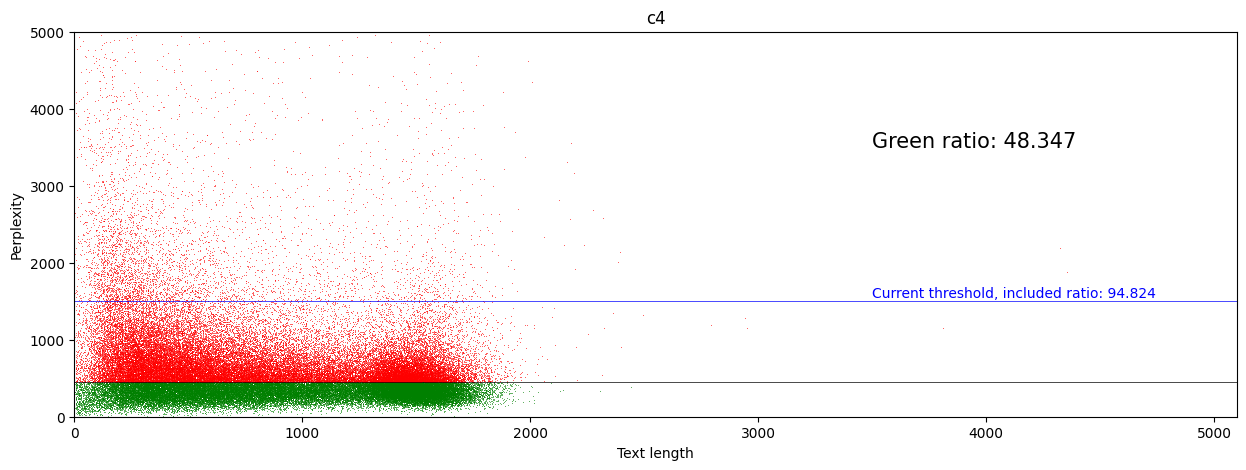

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [218]:
plot_full("c4", c4_cutoff, perplexity_key="passage_perplexity", length_key="passage_length")

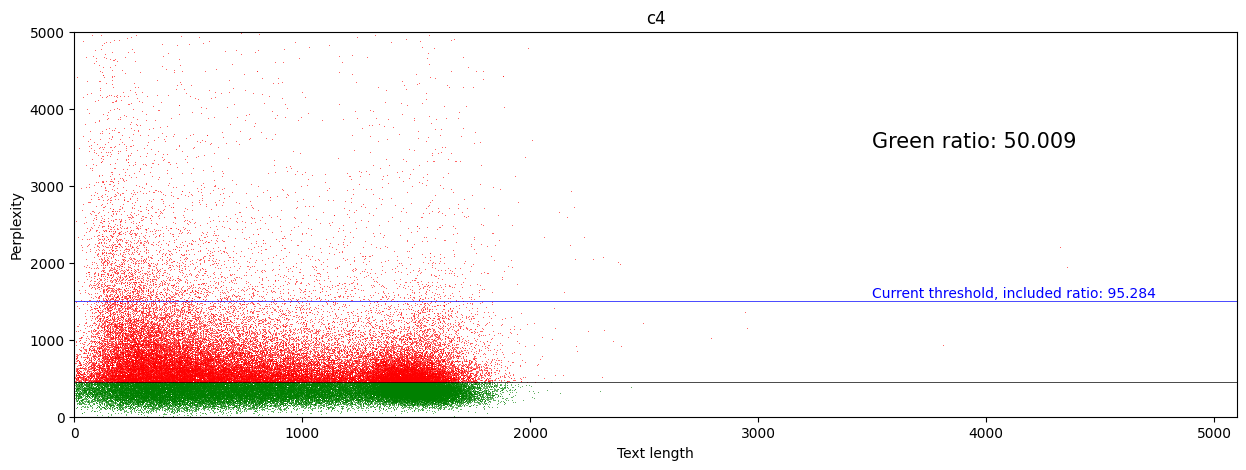

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [219]:
plot_full("c4", c4_cutoff, perplexity_key="perplexity_score", length_key="passage_length")

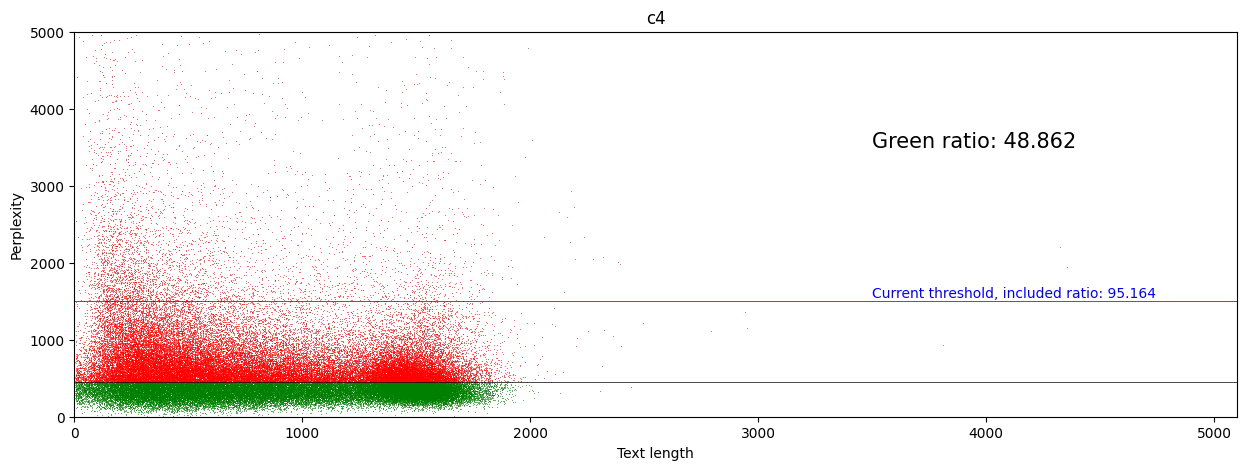

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [220]:
plot_full("c4", c4_cutoff, perplexity_key="max_perplexity", length_key="passage_length")

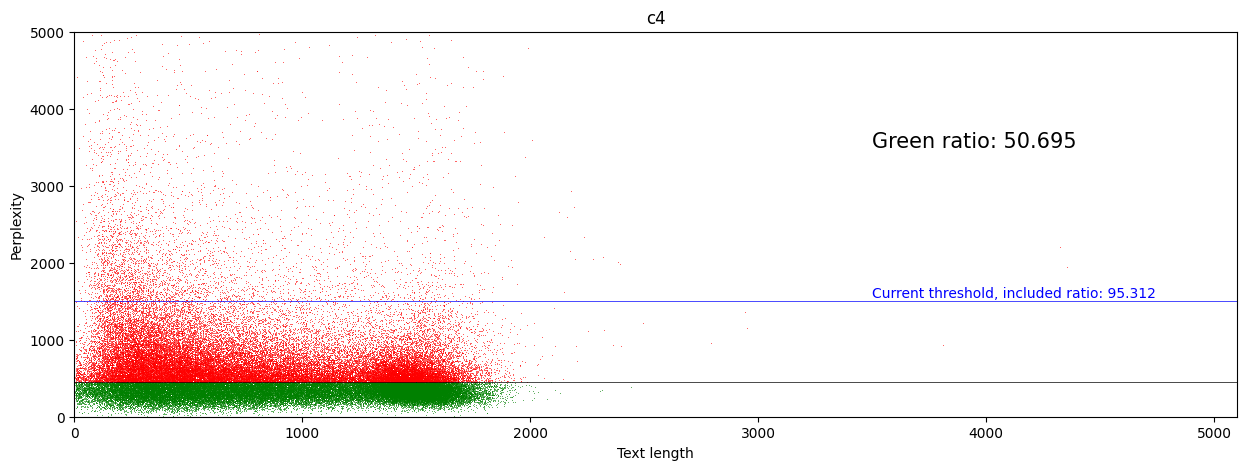

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [221]:
plot_full("c4", c4_cutoff, perplexity_key="min_perplexity", length_key="passage_length")